In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from lmfit import Model
from scipy.stats import linregress

In [48]:
# Variables

cv = pd.DataFrame()
l = pd.DataFrame()
d = pd.DataFrame()
cap = pd.DataFrame()
eff = pd.DataFrame()
eis_df = pd.DataFrame()
pitt_df = pd.DataFrame()

final_results = {}

F = 96485 # C/mol
col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']
col_iv = ['Potential applied (V)', 'Current (A)', 'Time (s)']
potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]
formatter_0 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))
palette = 'BuPu_r'

# Set up files for procedure 'Galv_Cyc_LMO_1C_Final_EIS_20230724.nox'

def setup_files(path):

    files = [os.path.join(path, i) for i in os.listdir(path)]
    folders = ['CV', 'lith', 'delith', 'EIS']
    
    for i in folders:
        if not os.path.exists(os.path.join(path, i)):
            os.mkdir(os.path.join(path, i))

    if not os.path.exists(os.path.join(path, 'EIS', 'Relaxis')):
        os.mkdir(os.path.join(path, 'EIS', 'Relaxis'))
        
    for i in os.listdir(path):
        if 'EIS_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'EIS', i))
            
    for i in os.listdir(os.path.join(path, 'EIS')):
        if 'relaxis' in i:
            os.rename(os.path.join(path, 'EIS', i), os.path.join(path, 'EIS', 'Relaxis', i))

    for i in os.listdir(path):
        if '_lith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
        elif '_delith' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
        elif i != 'README.txt' and len(i) > 7:
            os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
            
    for file_path in [os.path.join(os.path.join(path, 'EIS', 'Relaxis'), i) for i in os.listdir(os.path.join(path, 'EIS', 'Relaxis'))]:
        if '_relaxis' in file_path:
            # Extract the directory and filename from the file path
            directory, filename = os.path.split(file_path)
            
            # Extract the numeric part from the filename (assuming it's the last part before '_relaxis.txt')
            numeric_part = filename.split('_relaxis.txt')[0].split('EIS_')[-1]
            
            # Convert the numeric part to a float and format it to have 2 decimals
            numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
            
            # Create the new filename by replacing the numeric part
            new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
            
            # Create the new file path
            new_file_path = os.path.join(directory, new_filename)
        
            # # Rename the file
            if file_path != new_file_path:
                
                os.rename(file_path, new_file_path)
                print(f"Renamed: {file_path} => {new_file_path}")
                
    #add zero to cycles to have them sorted
    for file_path in [os.path.join(path, 'lith', i) for i in os.listdir(os.path.join(path, 'lith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        numeric_part = filename.split('_')[-1].split('.txt')[0]
        numeric_two_decimals = '{:02d}'.format(int(numeric_part))
    
        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, new_filename)
    
        if file_path != new_file_path:
                
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
            
    for file_path in [os.path.join(path, 'delith', i) for i in os.listdir(os.path.join(path, 'delith')) if i != 'README.txt']:
        directory, filename = os.path.split(file_path)
        numeric_part = filename.split('_')[-1].split('.txt')[0]
        numeric_two_decimals = '{:02d}'.format(int(numeric_part))

        new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
        new_file_path = os.path.join(directory, new_filename)

        if file_path != new_file_path:            
            os.rename(file_path, new_file_path)
            print(f"Renamed: {file_path} => {new_file_path}")
    
    # For PITT
    
    for filename in os.listdir(os.path.join(os.path.dirname(path), 'PITT')):
        
        # Extract the numeric part from the filename
        numeric_part = filename.split('_')[-1].split('.txt')[0]
    
    # # Convert the numeric part to a float and format it to have 2 decimals
        numeric_with_two_decimals = '{:.2f}'.format(float(numeric_part))
        
    # # Create the new filename by replacing the numeric part
        new_filename = filename.replace(numeric_part, numeric_with_two_decimals)
    
    # # Create the new file path
        new_file_path = os.path.join( os.path.join(os.path.dirname(path), 'PITT'), new_filename)

    # # # Rename the file
        if os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename) != new_file_path:
            os.rename(os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename), new_file_path)
            print(f"Renamed: {os.path.join(os.path.join(os.path.dirname(path), 'PITT'), filename)} => {new_file_path}")
       
# Methods
       
def cc(path, area, thickness, sample):
    
    cv_path = os.path.join(path, 'CV')
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    cv_df = pd.DataFrame()
    
    for i in sorted(os.listdir(cv_path), reverse=True): # sorted to get initial first
        f = os.path.join(cv_path, i)
        df = pd.read_csv(f, sep = ';', skiprows = 1, names = col_cv)
        df['Current_density_calc'] = df[col_cv[1]] / area
        if '_Initial_' in i:
            df['CV'] = 'Initial'
        else:
            df['CV'] = 'Final'
        cv_df = pd.concat([cv_df, df], ignore_index=True)
        
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    efficiency = pd.DataFrame()
    l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    n = 1
    for i in l:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  str(n) ### string or int
        df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        lithiation = pd.concat([lithiation, df], ignore_index=True)
        capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
        n += 1
    
    d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    n = 1
    for i in d:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        delithiation = pd.concat([delithiation, df], ignore_index=True)
        capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
        n += 1
        
    capacity = pd.concat([capacity_l, capacity_d], ignore_index=True) #, capacity_d
    efficiency['Efficiency (%)'] = capacity_l['Capacity (mAh/cm$^3$)'] / capacity_d['Capacity (mAh/cm$^3$)'] * 100
    efficiency['Cycle'] = capacity_l['Cycle']
    # ###
    results = [cv_df, lithiation, delithiation, capacity, efficiency]#, eff]#, efficiency]
    for i in results:
        i['Sample'] = sample
    # ###

    return results#results #cv_df, lithiation, delithiation, capacity, efficiency

def cc_ext(path, area, thickness, sample):
    
    cv_path = os.path.join(path, 'CV')
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    cv_df = pd.DataFrame()
    
    
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    efficiency = pd.DataFrame()
    l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    n = 1
    for i in l:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  str(n) ### string or int
        df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        lithiation = pd.concat([lithiation, df], ignore_index=True)
        capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
        n += 1
    
    d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    n = 1
    for i in d:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        delithiation = pd.concat([delithiation, df], ignore_index=True)
        capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
        n += 1
        
    capacity = pd.concat([capacity_l, capacity_d], ignore_index=True) #, capacity_d
    efficiency['Efficiency (%)'] = capacity_l['Capacity (mAh/cm$^3$)'] / capacity_d['Capacity (mAh/cm$^3$)'] * 100
    efficiency['Cycle'] = capacity_l['Cycle']
    # ###
    results = [cv_df, lithiation, delithiation, capacity, efficiency]#, eff]#, efficiency]
    for i in results:
        i['Sample'] = sample
    # ###

    return results#results #cv_df, lithiation, delithiation, capacity, efficiency

def eis(path, sample):
    
    col = ["Frequency (Hz)", "Z'", "-Z''", "Fit Frequency (Hz)", "Fit Z'", "Fit -Z''" ]
    
    path = os.path.join(path, 'EIS', 'Relaxis')
    files = [os.path.join(path, i) for i in os.listdir(path)]
    eis_data = pd.DataFrame()
    spectra = pd.DataFrame()
    m = 0
    for i in files:
        if 'Fit' in i:
            df = pd.read_csv(i, sep = '\t', skiprows = 2)
            df = df.rename(columns={'FreeVariable' : col_cv[0], 
                                    'Resistance 1: value' : 'Electrolyte Resistance ($\Omega$)', 
                                    'Resistance 2: value' : 'Charge Transfer Resistance ($\Omega$)',
                                    'CPE Q 1: value' : 'Double Layer Capacitance ($\mu$F)'})
            eis_data = pd.concat([eis_data, df], ignore_index=True)
            

        if 'Spectra' in i:
            df_s = pd.read_csv(i, skiprows=4, sep = '\t', names=col)

            df_s[col[2]] = -df_s[col[2]]
            df_s[col[5]] = -df_s[col[5]]
            df_s[col_cv[0]] = potentials[m]
            spectra = pd.concat([spectra, df_s], ignore_index=True)
            m += 1
            
    #     k += 1
    eis_data['Sample'] = sample
    spectra['Sample'] = sample
    eis = [eis_data, spectra]
    return eis #eis_data, spectra

def pitt(path, area, thickness, skip, sample):
    path = os.path.join(os.path.dirname(path), 'PITT')
    thickness = thickness * 1e-7
# PITT Model to fit
    def PITT(t, delta_q, D, i_b): #t, S, C, D, L ):
        # return ((2 *F * S * C * D)/L) * np.exp(-(np.pi**2 * D * t) / (4 * L ** 2))
        return (2 * delta_q * D / (thickness ** 2)) * np.exp(-((np.pi ** 2) * D * t / (4 * (thickness** 2)))) + i_b
    gmodel = Model(PITT)
    params = gmodel.make_params() 
    params['D'].set(value = 1e-10, min = 1e-20, max = 1e-5)
    # params['L'].set(value = 80e-7, vary = False)
    params['delta_q'].set(value = 0.1, min = 1e-22)
    params['i_b'].set(value = 3e-7, min = 0)

    #Data Analysis
    # def pitt_data(path, area, thickness, skip, sample):
    data = pd.DataFrame()
    fit_vals = pd.DataFrame(columns = col2)
    fit_reports = []
    files = [os.path.join(path, i) for i in os.listdir(path)]
    n = 0
    for i in files:
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col,  engine = 'python', skipfooter = skip) #4000
        fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
        df['Step'] = i[-8:-4]
        df['Fit'] = fit.best_fit
        data = pd.concat([data, df], ignore_index = True)
        fit_reports.append(fit.fit_report())
        fit_vals.loc[n] = (float(i[-8:-4]), fit.values['D'], fit.values['delta_q'], fit.values['delta_q']/(F * area * thickness))
        n += 1
    data['Sample'] = sample
    fit_vals['Sample'] = sample
    results = [data, fit_vals, fit_reports]
    return results

def compare(results, add_eis_df, add_pitt_df, add):
    global cv, l, d, cap, eff, eis_df, pitt_df
    if add == True:
        cv = pd.concat([cv, results[0]], ignore_index = True)
        l = pd.concat([l, results[1]], ignore_index = True)
        d = pd.concat([d, results[2]], ignore_index = True)
        cap = pd.concat([cap, results[3]], ignore_index = True)
        eff = pd.concat([eff, results[4]], ignore_index = True)
        eis_df = pd.concat([eis_df, add_eis_df[0]], ignore_index = True)
        pitt_df = pd.concat([pitt_df, add_pitt_df[1]], ignore_index = True)

def cc_plot(cc_df, sample, dpi):
    # Plots
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
    # sns.scatterplot(data = cc_df[0], x = col_cv[0], y = col_cv[4], edgecolor = None, s =1, ax = ax[0], hue = 'CV', palette = palette)
    sns.scatterplot(data = cc_df[0], x = col_cv[0], y = 'Current_density_calc', edgecolor = None, s =1, ax = ax[0], hue = 'Scan', palette = palette)
    ax[0].set_ylabel(col_cv[4])
    sns.lineplot(data = cc_df[1], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', palette = palette, legend = False)
    sns.lineplot(data = cc_df[2], x = 'Capacity_calc', y = col_cv[0], hue = 'Cycle', legend = False, palette = palette)
    ax[0].yaxis.set_major_formatter(formatter)
    ax[1].set_xlabel('Capacity (mAh/cm$^3$)')
    fig.suptitle(sample)
    

    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = dpi)
    sns.scatterplot(data = cc_df[3], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'L/D', palette=palette, ax = ax[0])
    sns.scatterplot(data = cc_df[4], x = 'Cycle', y = 'Efficiency (%)', ax = ax[1])

def eis_plot(eis_df, dpi):
    fig, ax = plt.subplots(dpi = dpi)
    sns.barplot(data = eis_df[0], x = 'Potential vs Li$^+$/Li (V)', y = 'Charge Transfer Resistance ($\Omega$)', palette = palette)
    
def pitt_plot(df, sample):
    fig, ax = plt.subplots(2,2, dpi =200, figsize = (15,10))
    sns.scatterplot(data = df[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
    sns.scatterplot(data = df[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
    sns.scatterplot(data = df[1], x = col2[0], y = col2[1], ax = ax[1,0])
    sns.scatterplot(data = df[1], x = col2[0], y = col2[3])
    ax[0,1].yaxis.set_major_formatter(formatter)
    ax[1,0].set_yscale('log')
    # ax[1,0].set_ylim(2e-12, 2e-10)
    fig.suptitle(sample)

<AxesSubplot: xlabel='Capacity (mAh/cm$^3$)', ylabel='Potential vs Li$^+$/Li (V)'>

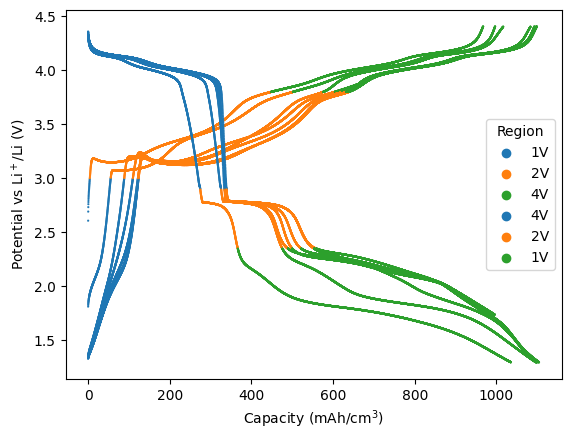

In [49]:
def cc_ext(path, area, thickness, sample):
    
    lith_path = os.path.join(path, 'lith')
    delith_path = os.path.join(path, 'delith')
    
    
    lithiation = pd.DataFrame()
    delithiation = pd.DataFrame()
    capacity_l = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    capacity_d = pd.DataFrame(columns = ['Capacity (mAh/cm$^3$)', 'Cycle', 'L/D'])
    efficiency = pd.DataFrame()
    l = [os.path.join(lith_path, i) for i in os.listdir(lith_path)]
    n = 1
    for i in l:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df.loc[df[col_cv[0]] > 2.9, 'Region'] = '4V'
        df.loc[df[col_cv[0]] < 2.9, 'Region'] = '2V'
        df.loc[df[col_cv[0]] < 2.35, 'Region'] = '1V'

        df['Cycle'] =  str(n) ### string or int
        df['Capacity_calc'] = -df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        lithiation = pd.concat([lithiation, df], ignore_index=True)
        capacity_l.loc[n] = (max(df['Capacity_calc']), n, 'Lithiation')
        n += 1
    
    d = [os.path.join(delith_path, i) for i in os.listdir(delith_path)]
    n = 1
    for i in d:
        df = pd.read_csv(i, sep = ';')
        df = df.rename(columns={'WE(1).Potential (V)': col_cv[0], 'Capacity (mAh/cm3)': 'Capacity (mAh/cm$^3$)'})
        df.loc[df[col_cv[0]] > 3.8, 'Region'] = '4V'
        df.loc[df[col_cv[0]] < 3.8, 'Region'] = '2V'
        df.loc[df[col_cv[0]] < 3, 'Region'] = '1V'
        df['Cycle'] =  n #str(n) ### string or int
        df['Capacity_calc'] = df['WE(1).Charge (C)'] /3.6 / (area * 1e-7 * thickness)
        delithiation = pd.concat([delithiation, df], ignore_index=True)
        capacity_d.loc[n] = (max(df['Capacity_calc']), n, 'Delithiation')
        n += 1
        
    capacity = pd.concat([capacity_l, capacity_d], ignore_index=True) #, capacity_d
    efficiency['Efficiency (%)'] = capacity_l['Capacity (mAh/cm$^3$)'] / capacity_d['Capacity (mAh/cm$^3$)'] * 100
    efficiency['Cycle'] = capacity_l['Cycle']
    # ###
    results = [lithiation, delithiation, capacity, efficiency]#, eff]#, efficiency]
    for i in results:
        i['Sample'] = sample
    # ###

    return results#results #cv_df, lithiation, delithiation, capacity, efficiency


# ALD TiO2 90 cycles extended window
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\ALD TiO2\90cycles_ext'
area = 3.1416
thickness = 90
sample = 'LMO2h ALD TIO2 7nm'
ald_tio2_ext = cc_ext(path, area, thickness, sample )

aa = ald_tio2_ext[1]
a = ald_tio2_ext[0]

sns.scatterplot(data = aa, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', hue = 'Region', edgecolor = None, s = 2)
sns.scatterplot(data = a, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', hue = 'Region', edgecolor = None, s = 2)

In [51]:
# Areas
def um2_cm2(um2):
    return um2 / 1e8
    
s02_area_um2 = 22977500 #um2
s05_area_um2 = 22989744 # um2
s10_area_um2 = 18940450 # um2
s20_area_um2 = 26121241 # um2
s02_area_cm2 = um2_cm2(s02_area_um2)
s05_area_cm2 = um2_cm2(s05_area_um2)
s10_area_cm2 = um2_cm2(s10_area_um2)
s20_area_cm2 = um2_cm2(s20_area_um2)
s20_area_cm2


0.26121241

In [ ]:
################## L23_01 Structure S_05 ##################

# IV curve dry
iv_0 = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L23\L23_01\IV\L23_01_IV_dry.txt'
iv_0_df = pd.read_csv(iv_0, sep = ';', skiprows = 1, names = col_iv)

slope, intercept, rvalue, pvalue, stderr = linregress(iv_0_df[col_iv[0]], iv_0_df[col_iv[1]])
r = 1/slope
# print(str(r) + ' ohms')

fig, ax = plt.subplots(dpi = 100)
sns.lineplot(data = iv_0_df, x = col_iv[0], y = col_iv[1], label = 'Data')
#### ax.yaxis.set_major_formatter(formatter_0)
# plt.plot(iv_0_df[col_iv[0]], iv_0_df[col_iv[0]] * slope + intercept, label = 'Fit')
# plt.legend()

# IV curve wet
iv_1 = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L23\L23_01\IV\L23_01_IV_wet.txt'
iv_1_df = pd.read_csv(iv_1, sep = ';', skiprows = 1, names = col_iv)

slope, intercept, rvalue, pvalue, stderr = linregress(iv_1_df[col_iv[0]], iv_1_df[col_iv[1]])
r = 1/slope
# print(str(r) + ' ohms')

# fig, ax = plt.subplots(dpi = 100)
# sns.lineplot(data = iv_1_df, x = col_iv[0], y = col_iv[1], label = 'Data')
# ###ax.yaxis.set_major_formatter(formatter_0)
# plt.plot(iv_1_df[col_iv[0]], iv_1_df[col_iv[0]] * slope + intercept, label = 'Fit')
# plt.legend()

#Activation CV
a_cv_path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L23\L23_01\CV\L23_01_Activation_CV_Initial_CV_U_4.4_L_3.4.txt'
a_cv_df = pd.read_csv(a_cv_path, sep = ';', skiprows=1, names = col_cv)
# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = a_cv_df, x = col_cv[0], y = col_cv[1], edgecolor = None, s = 3)



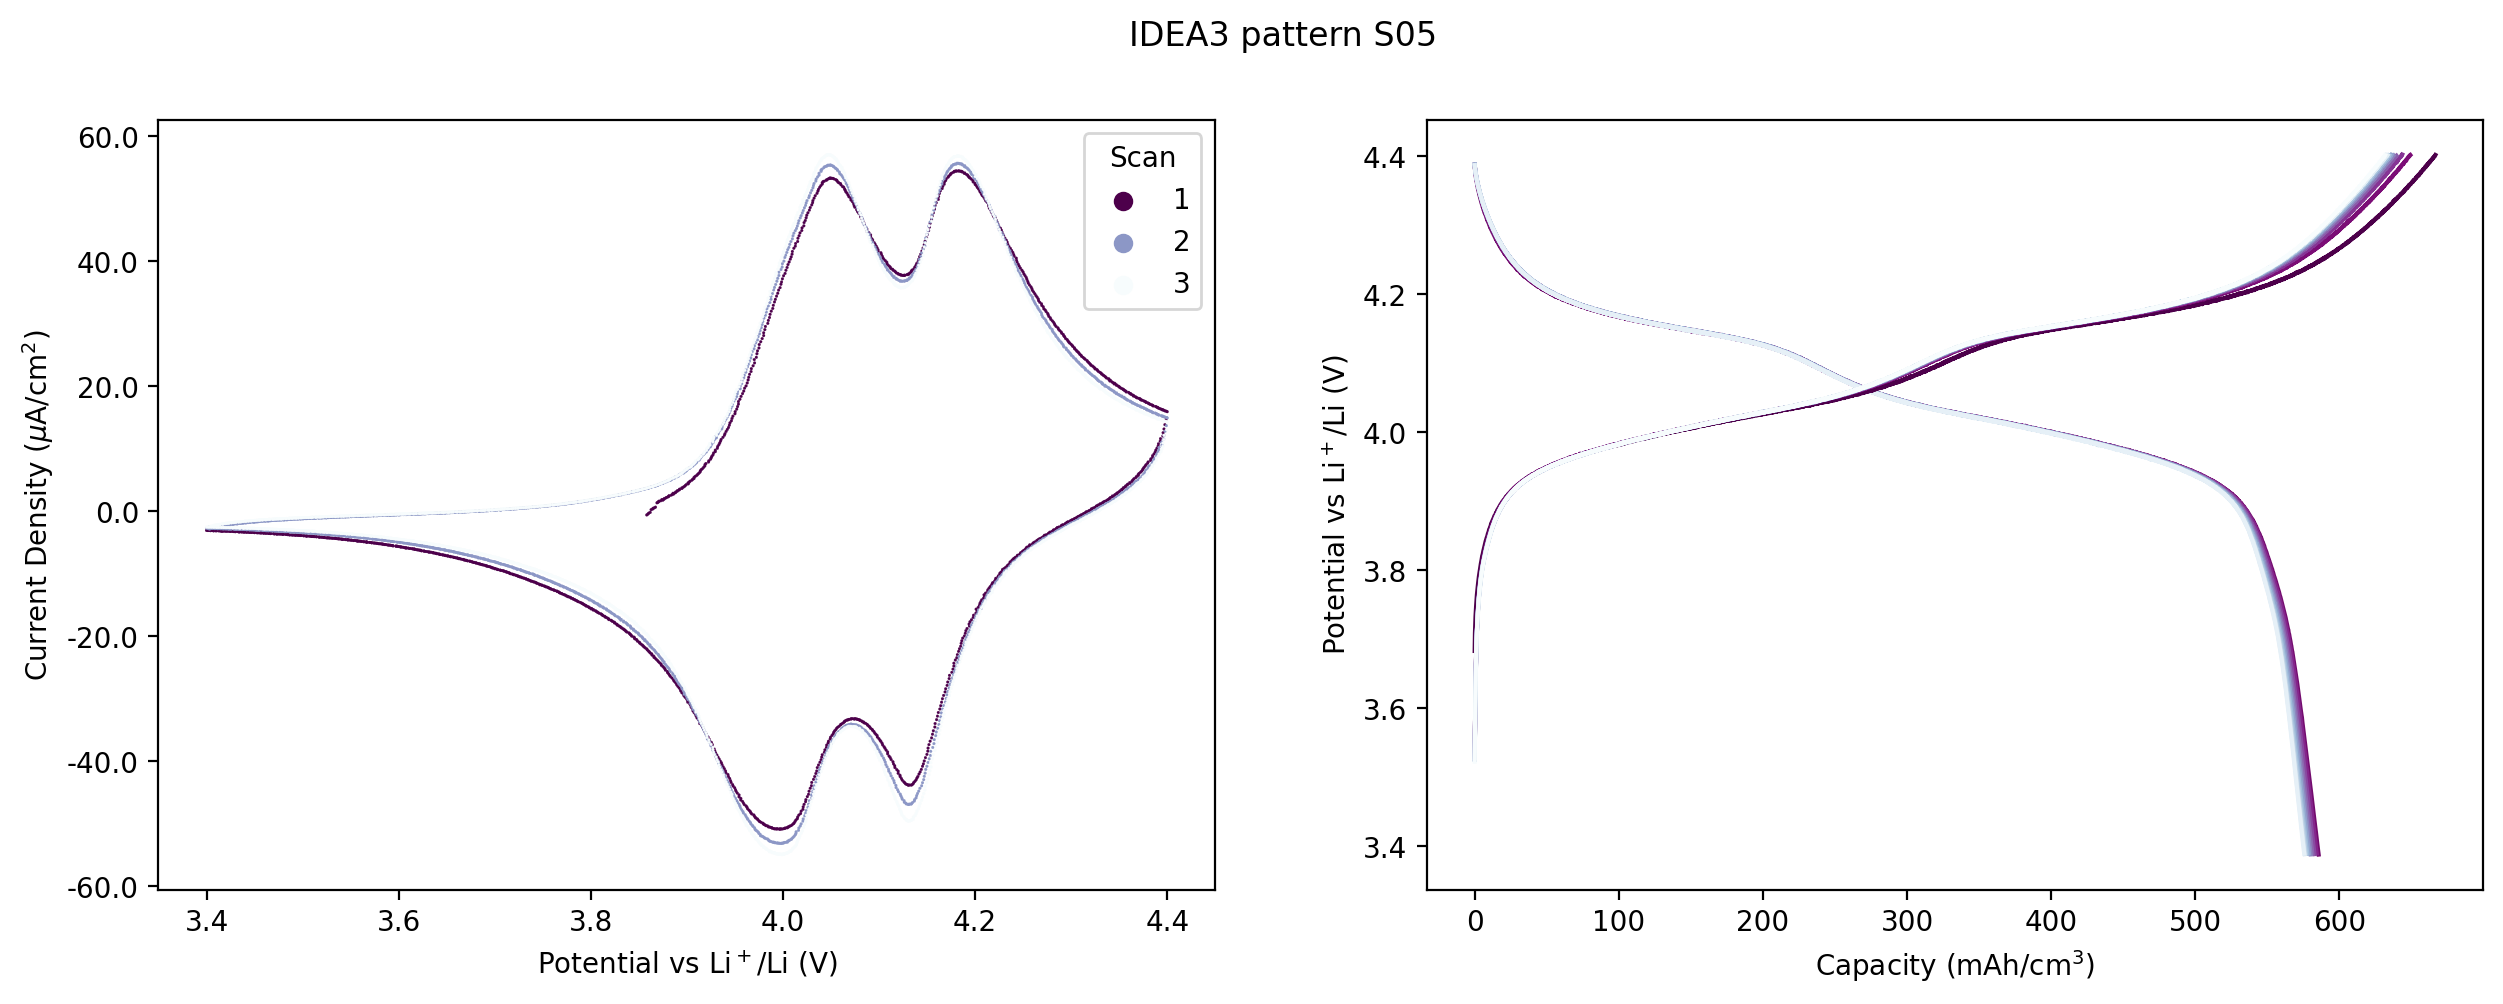

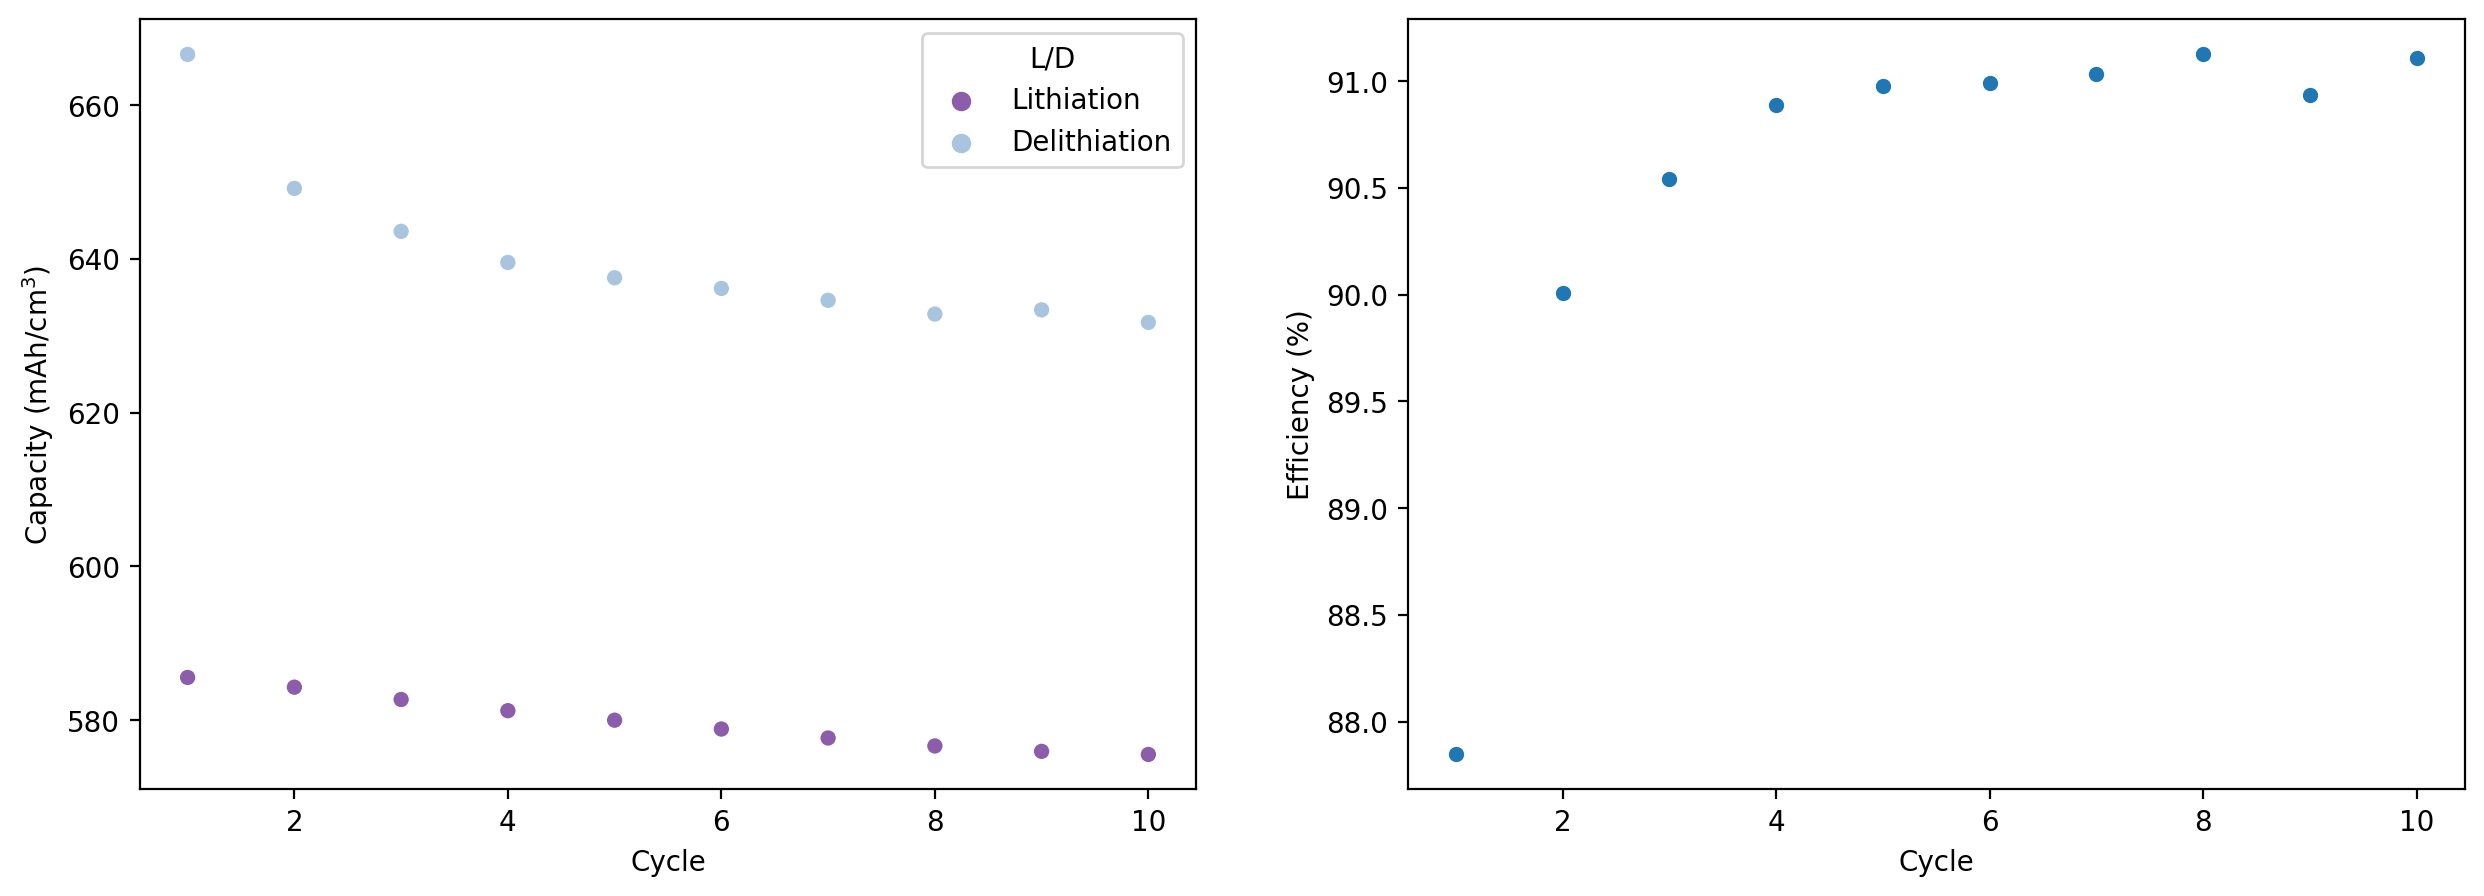

In [50]:
# L23_01 1C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L23\L23_01\1C'
area = s05_area_cm2
thickness = 90
sample = 'IDEA3 pattern S05'
# setup_files(path)
l23_01_1c = cc(path, area, thickness, sample )
cc_plot(l23_01_1c, sample, 200)


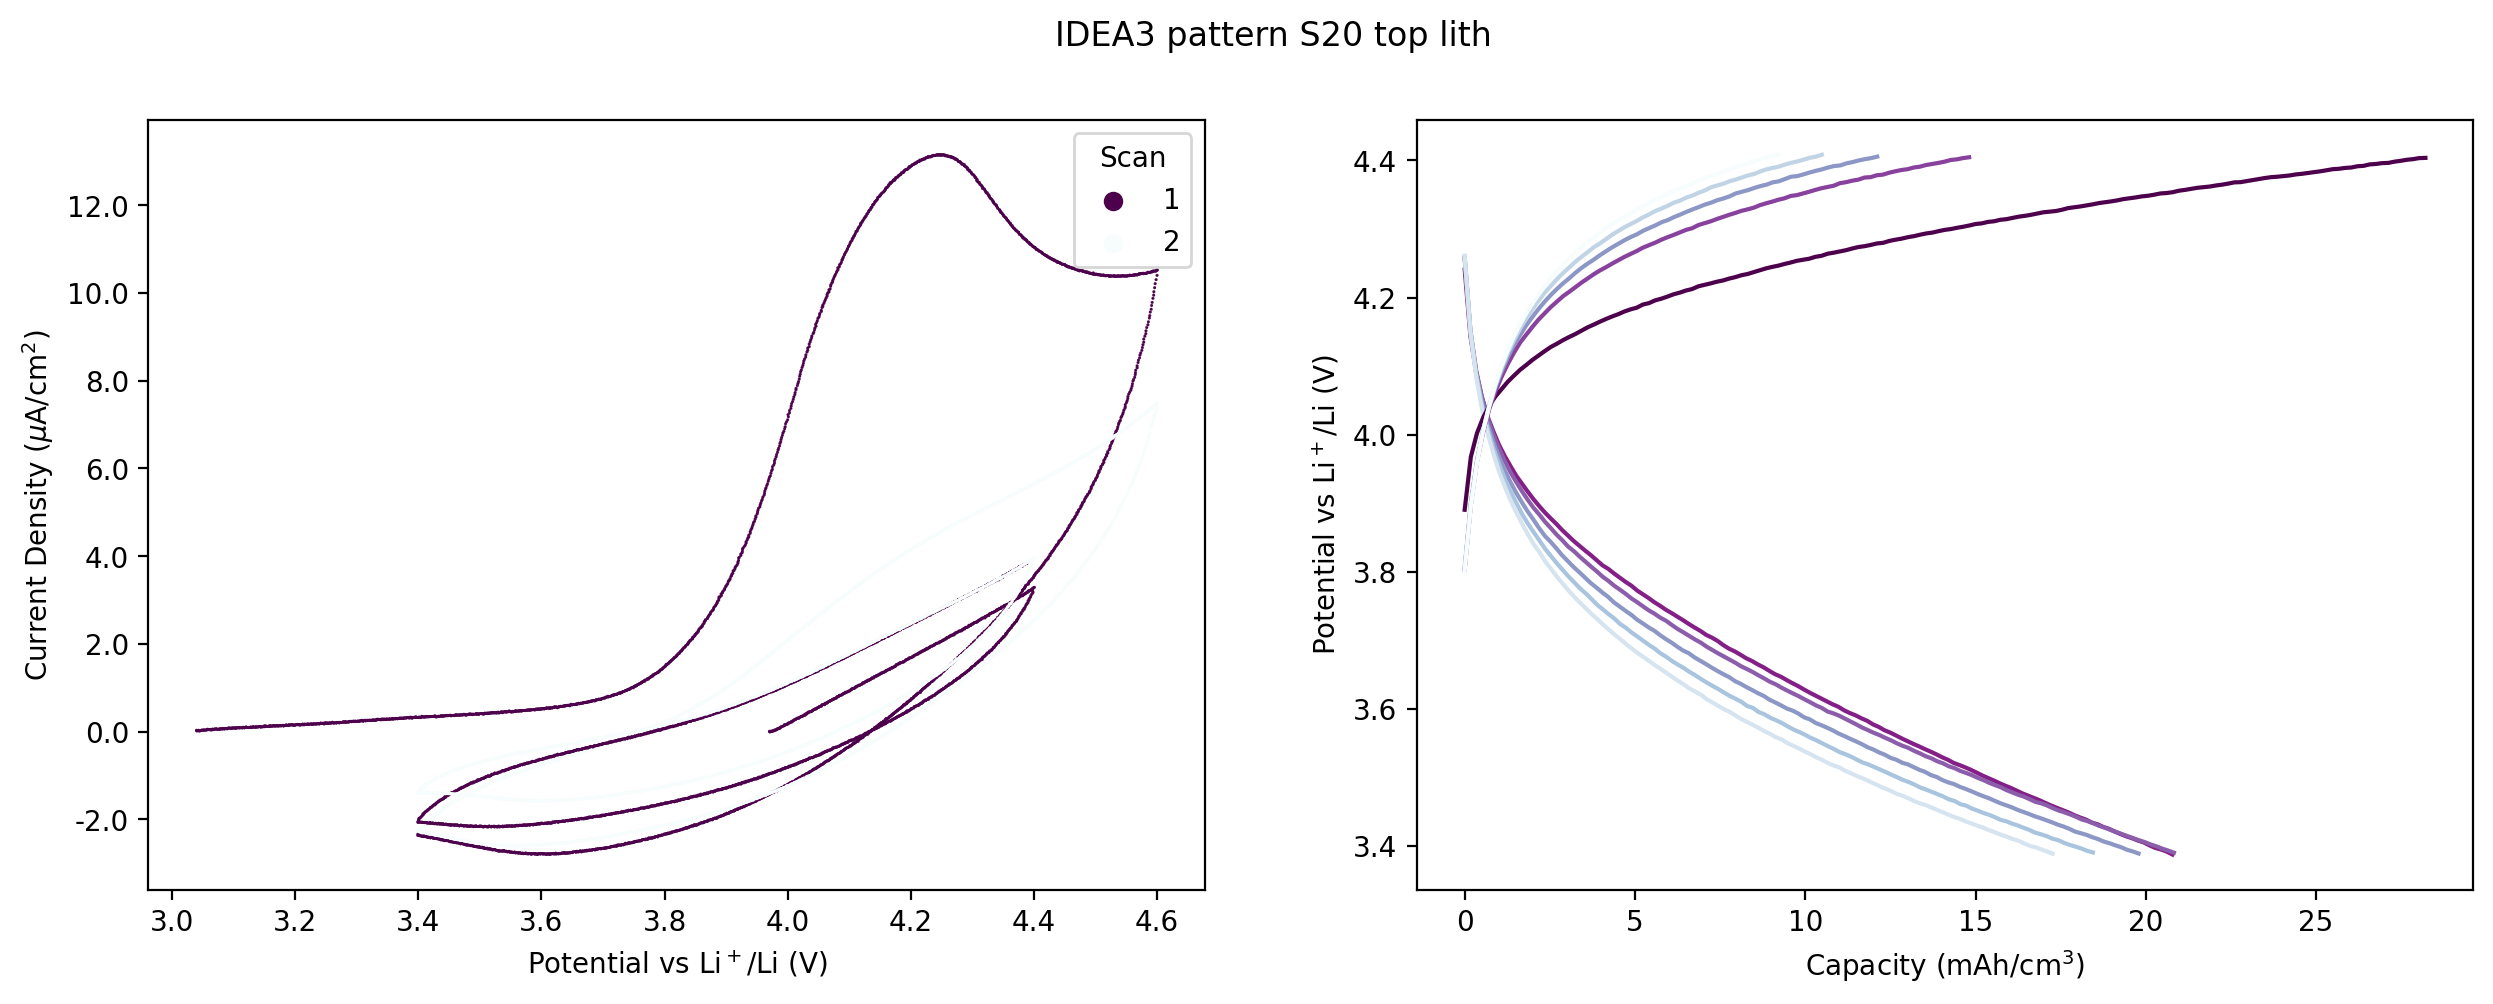

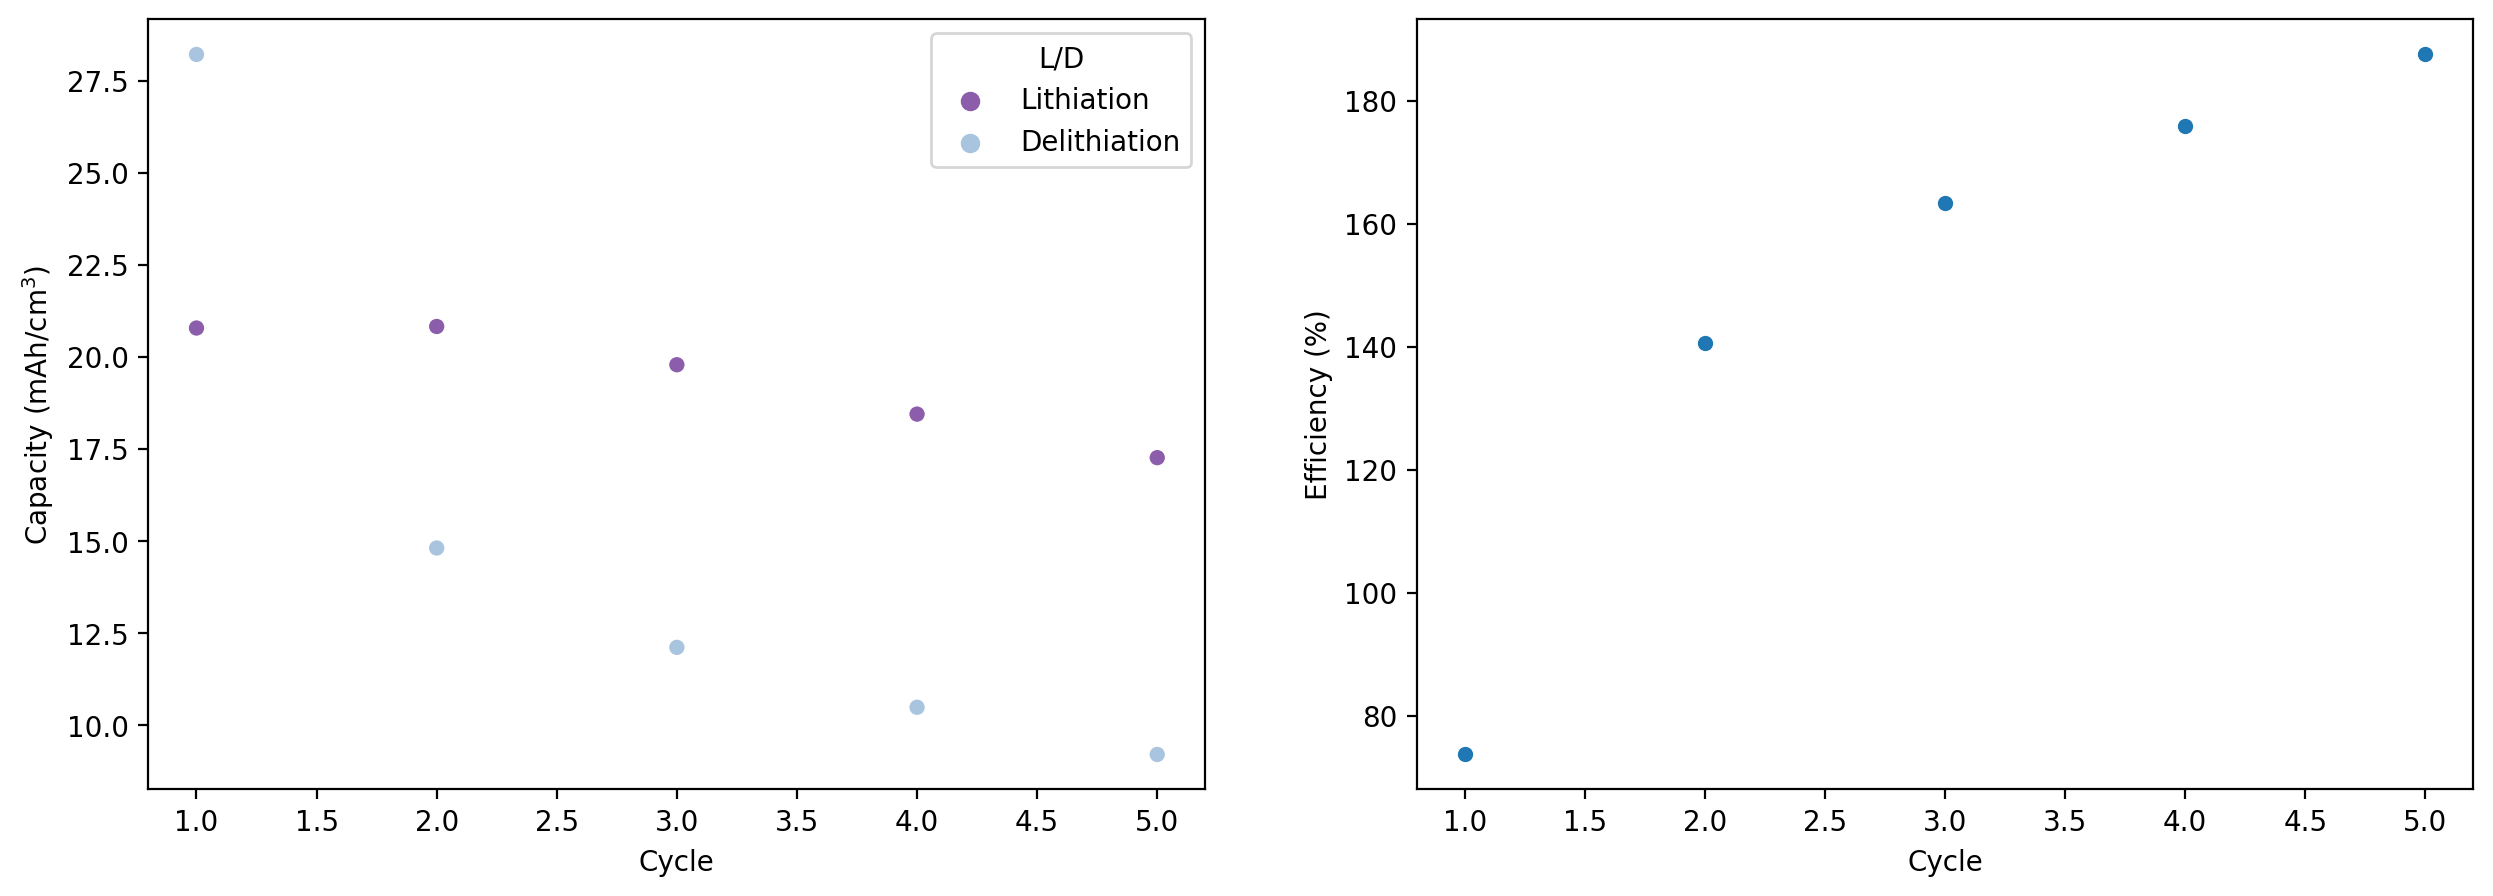

In [52]:
# Top lith
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\TopLith\S20\1C'
area = s20_area_cm2
thickness = 90
sample = 'IDEA3 pattern S20 top lith'
# setup_files(path)
top_lith = cc(path, area, thickness, sample )
cc_plot(top_lith, sample, 200)


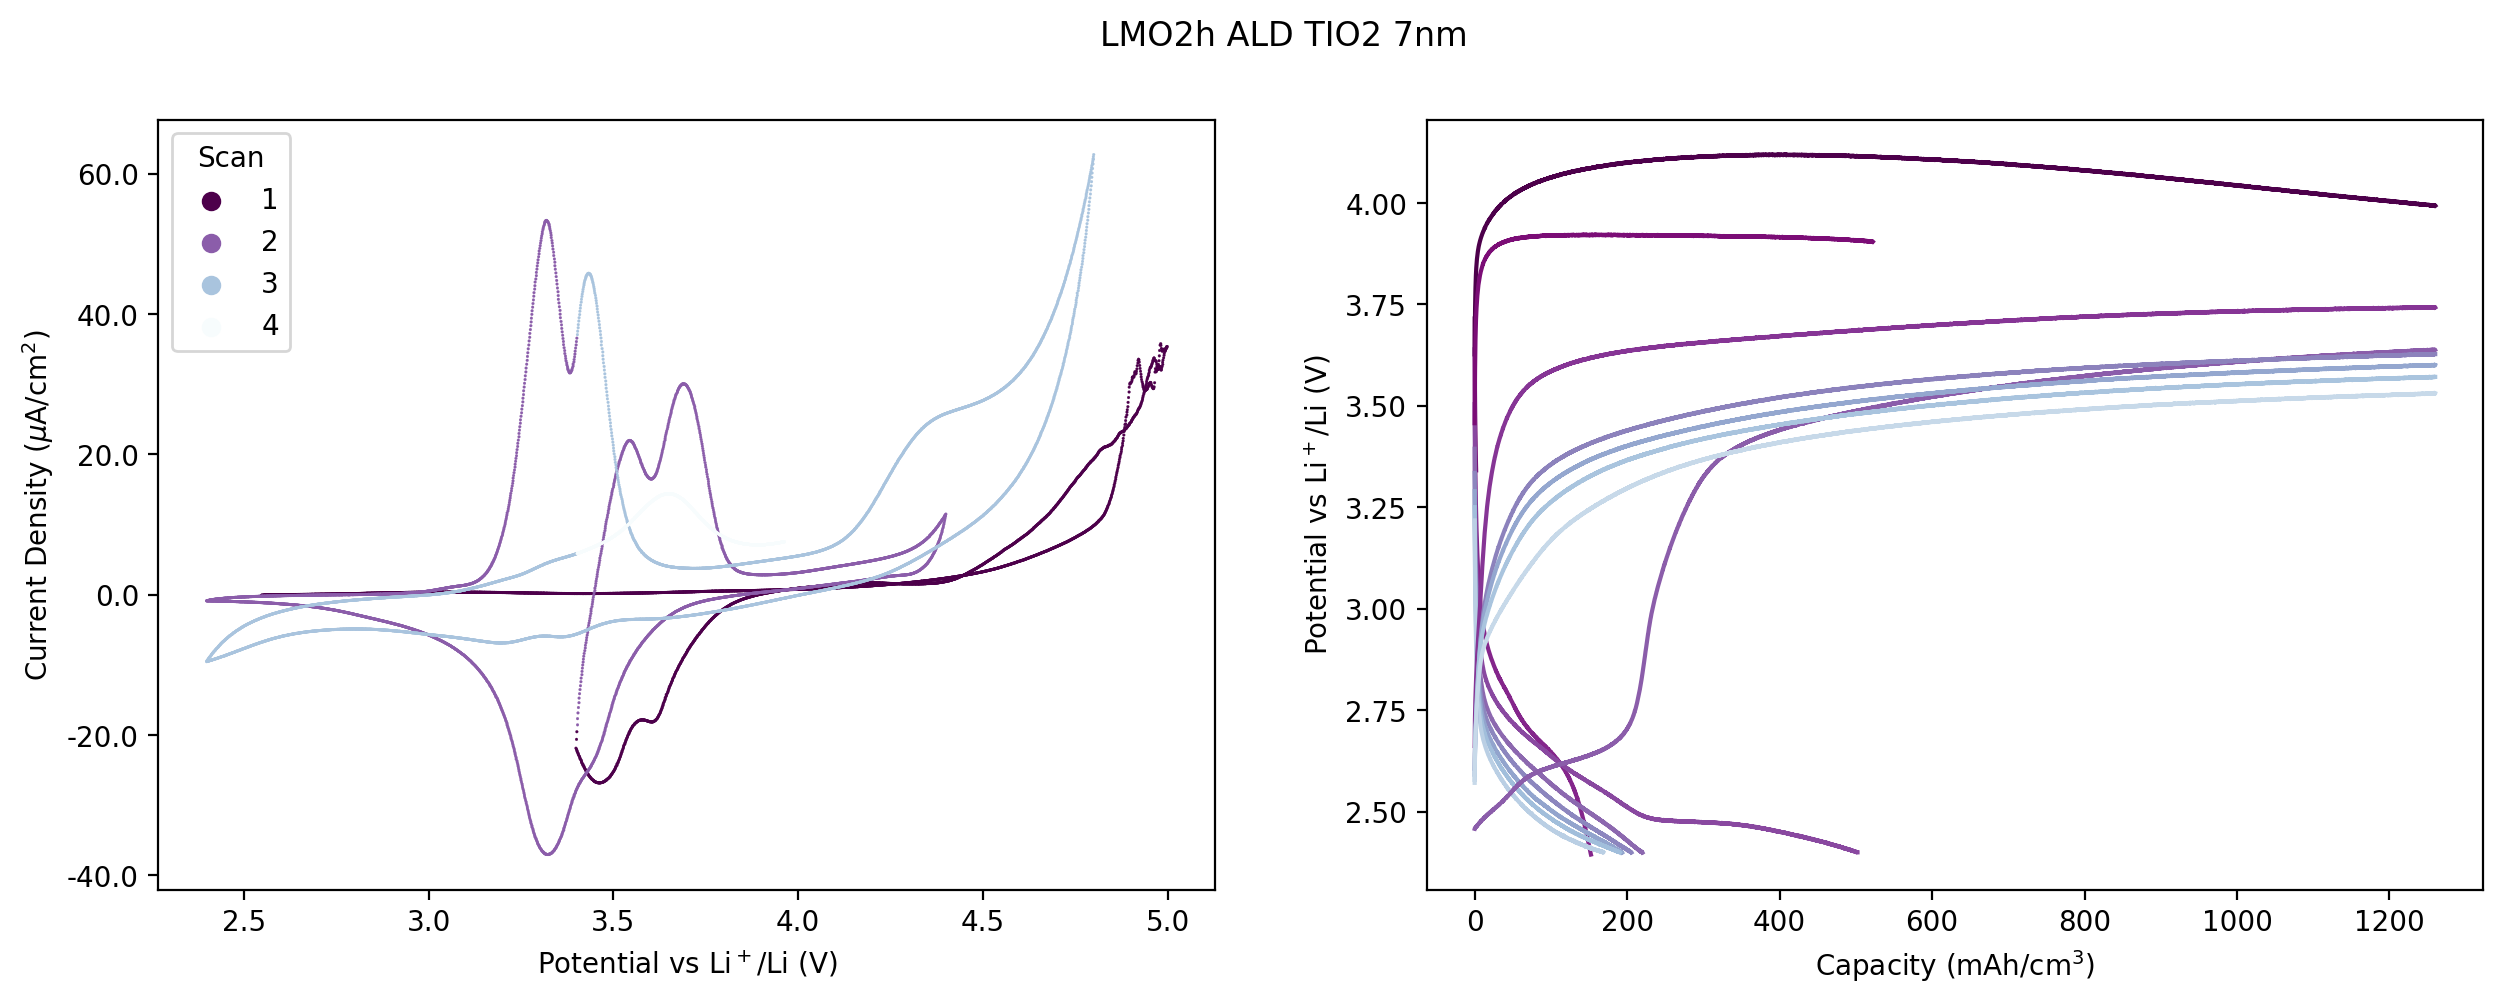

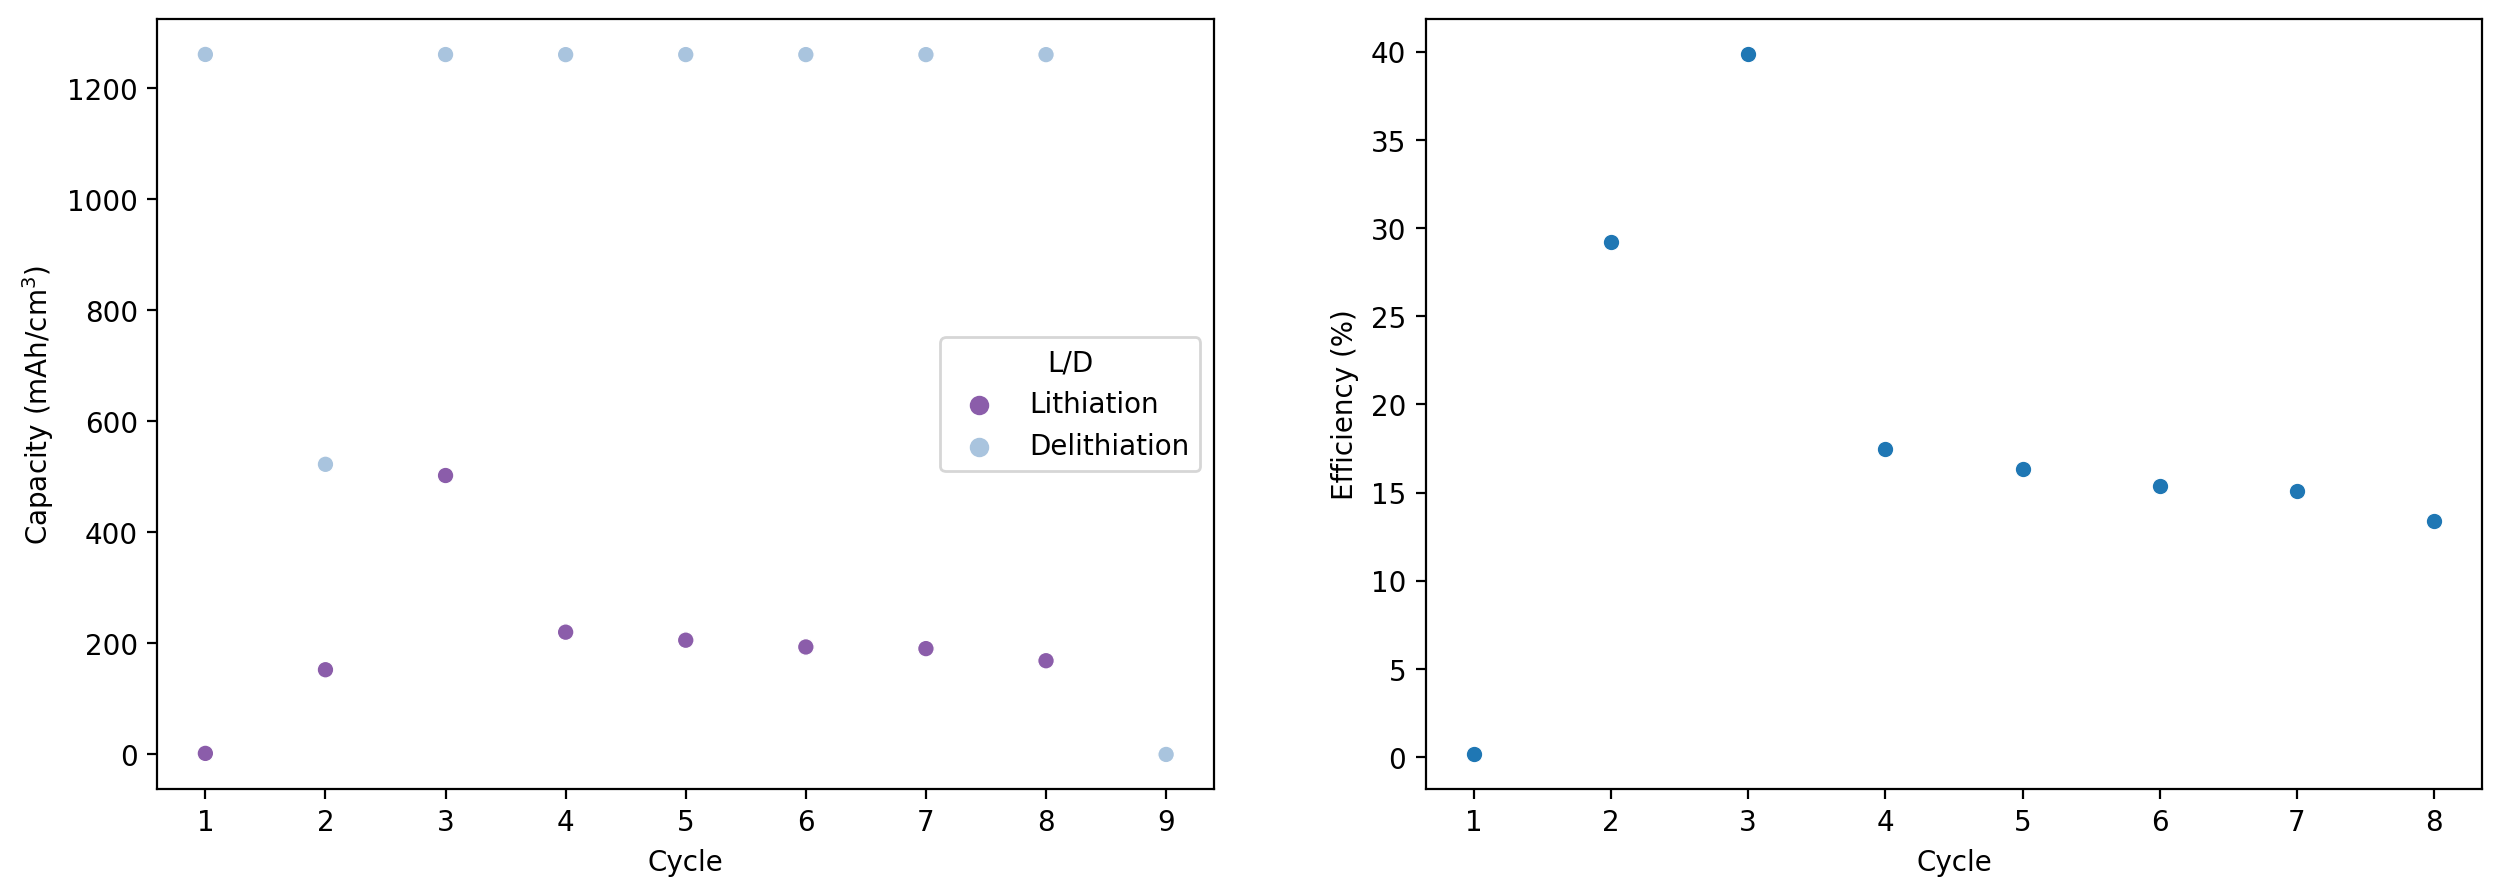

In [53]:
# LMO ALD TiO2 90 cycles 7nm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L23\L23_02\1C'
area = 3.1416
thickness = 90
sample = 'LMO2h ALD TIO2 7nm'
# setup_files(path)
l23_02_1c = cc(path, area, thickness, sample )
cc_plot(l23_02_1c, sample, 200)
# l23_01_1c[0]

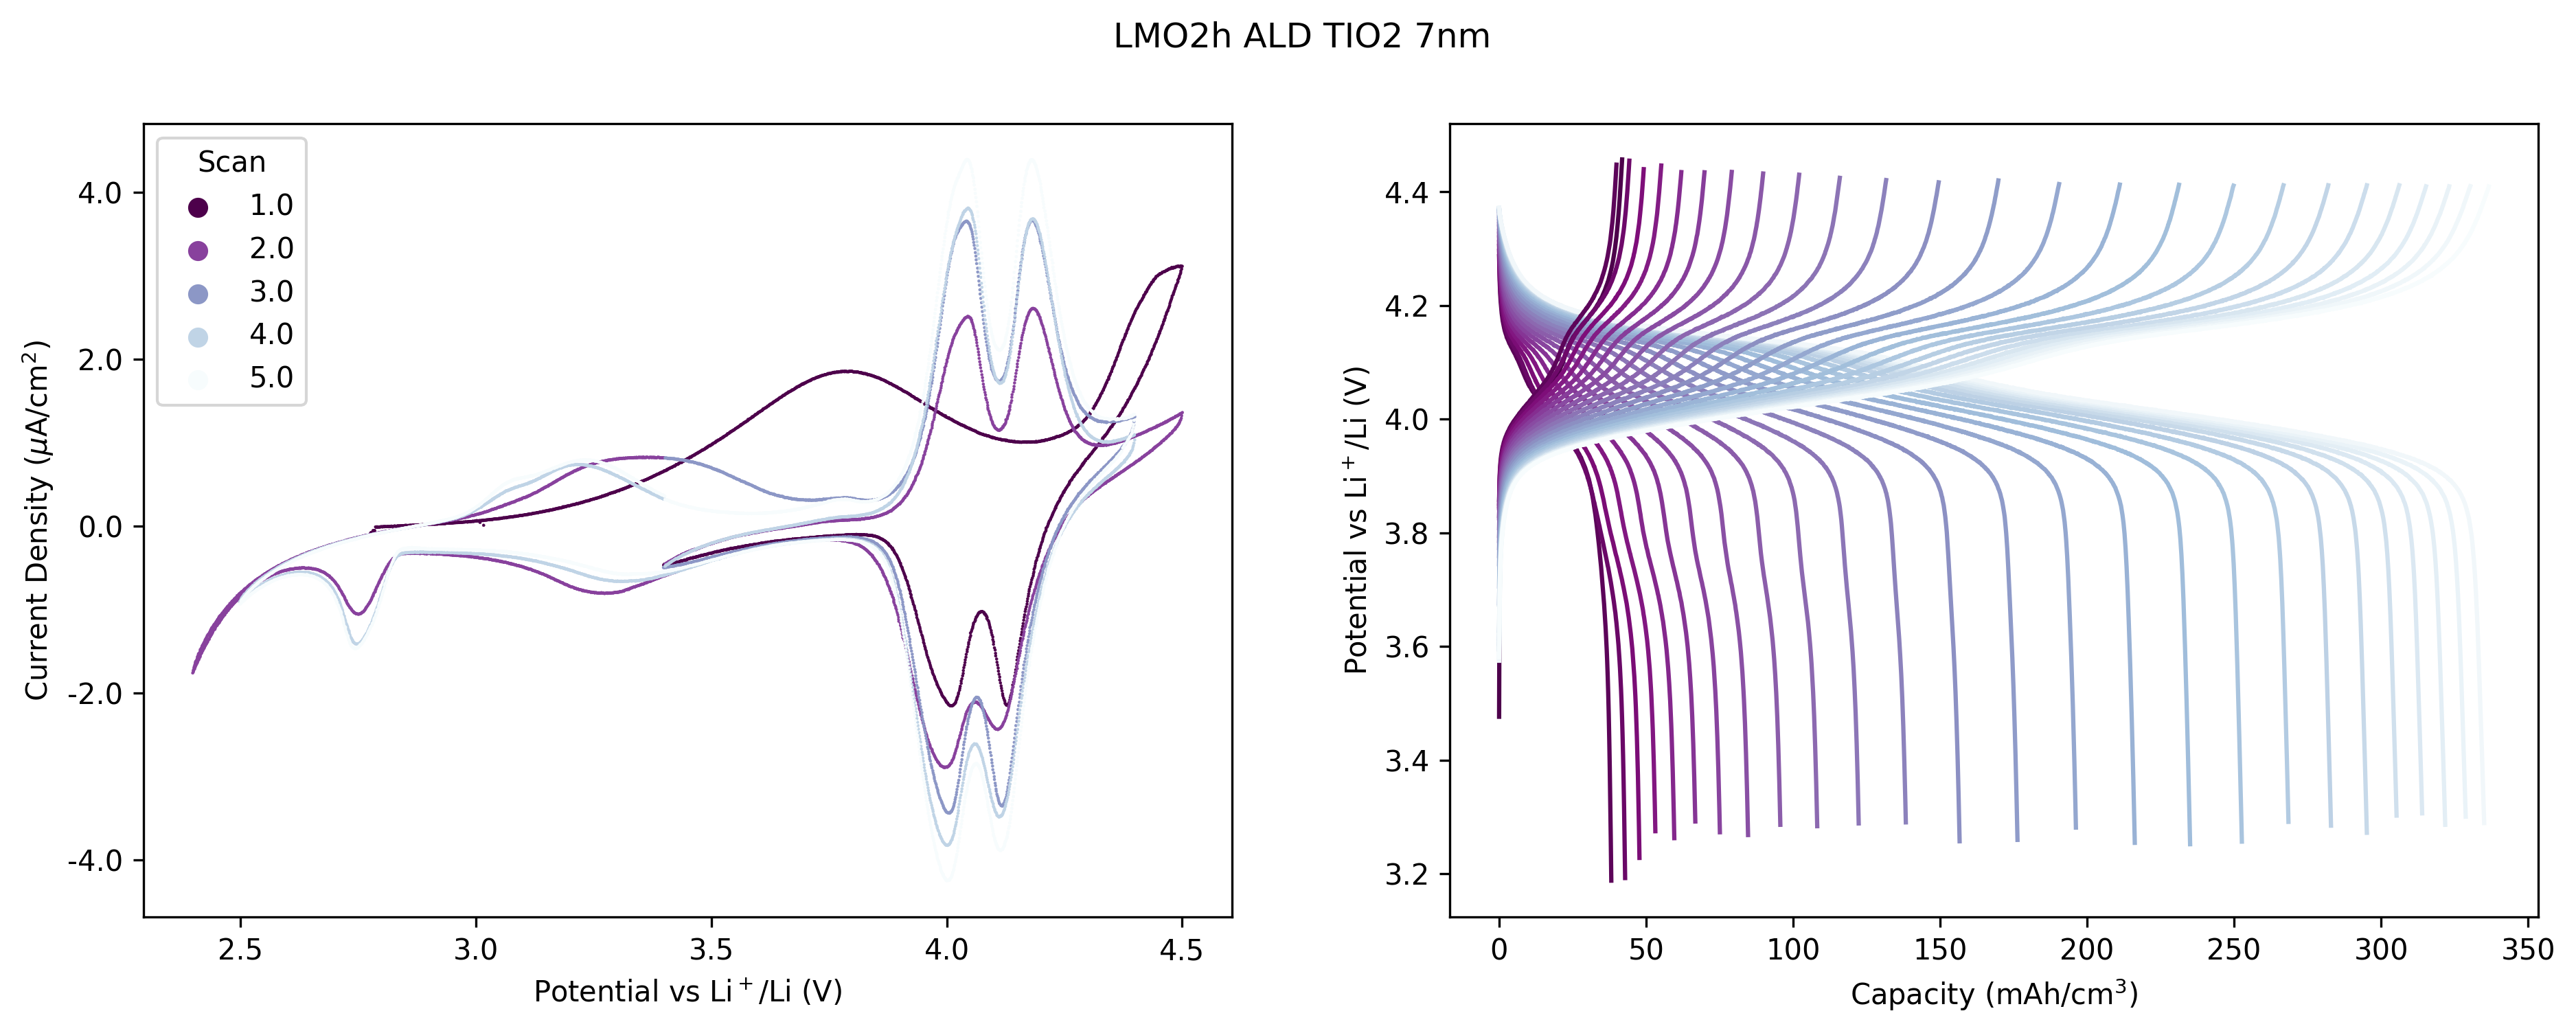

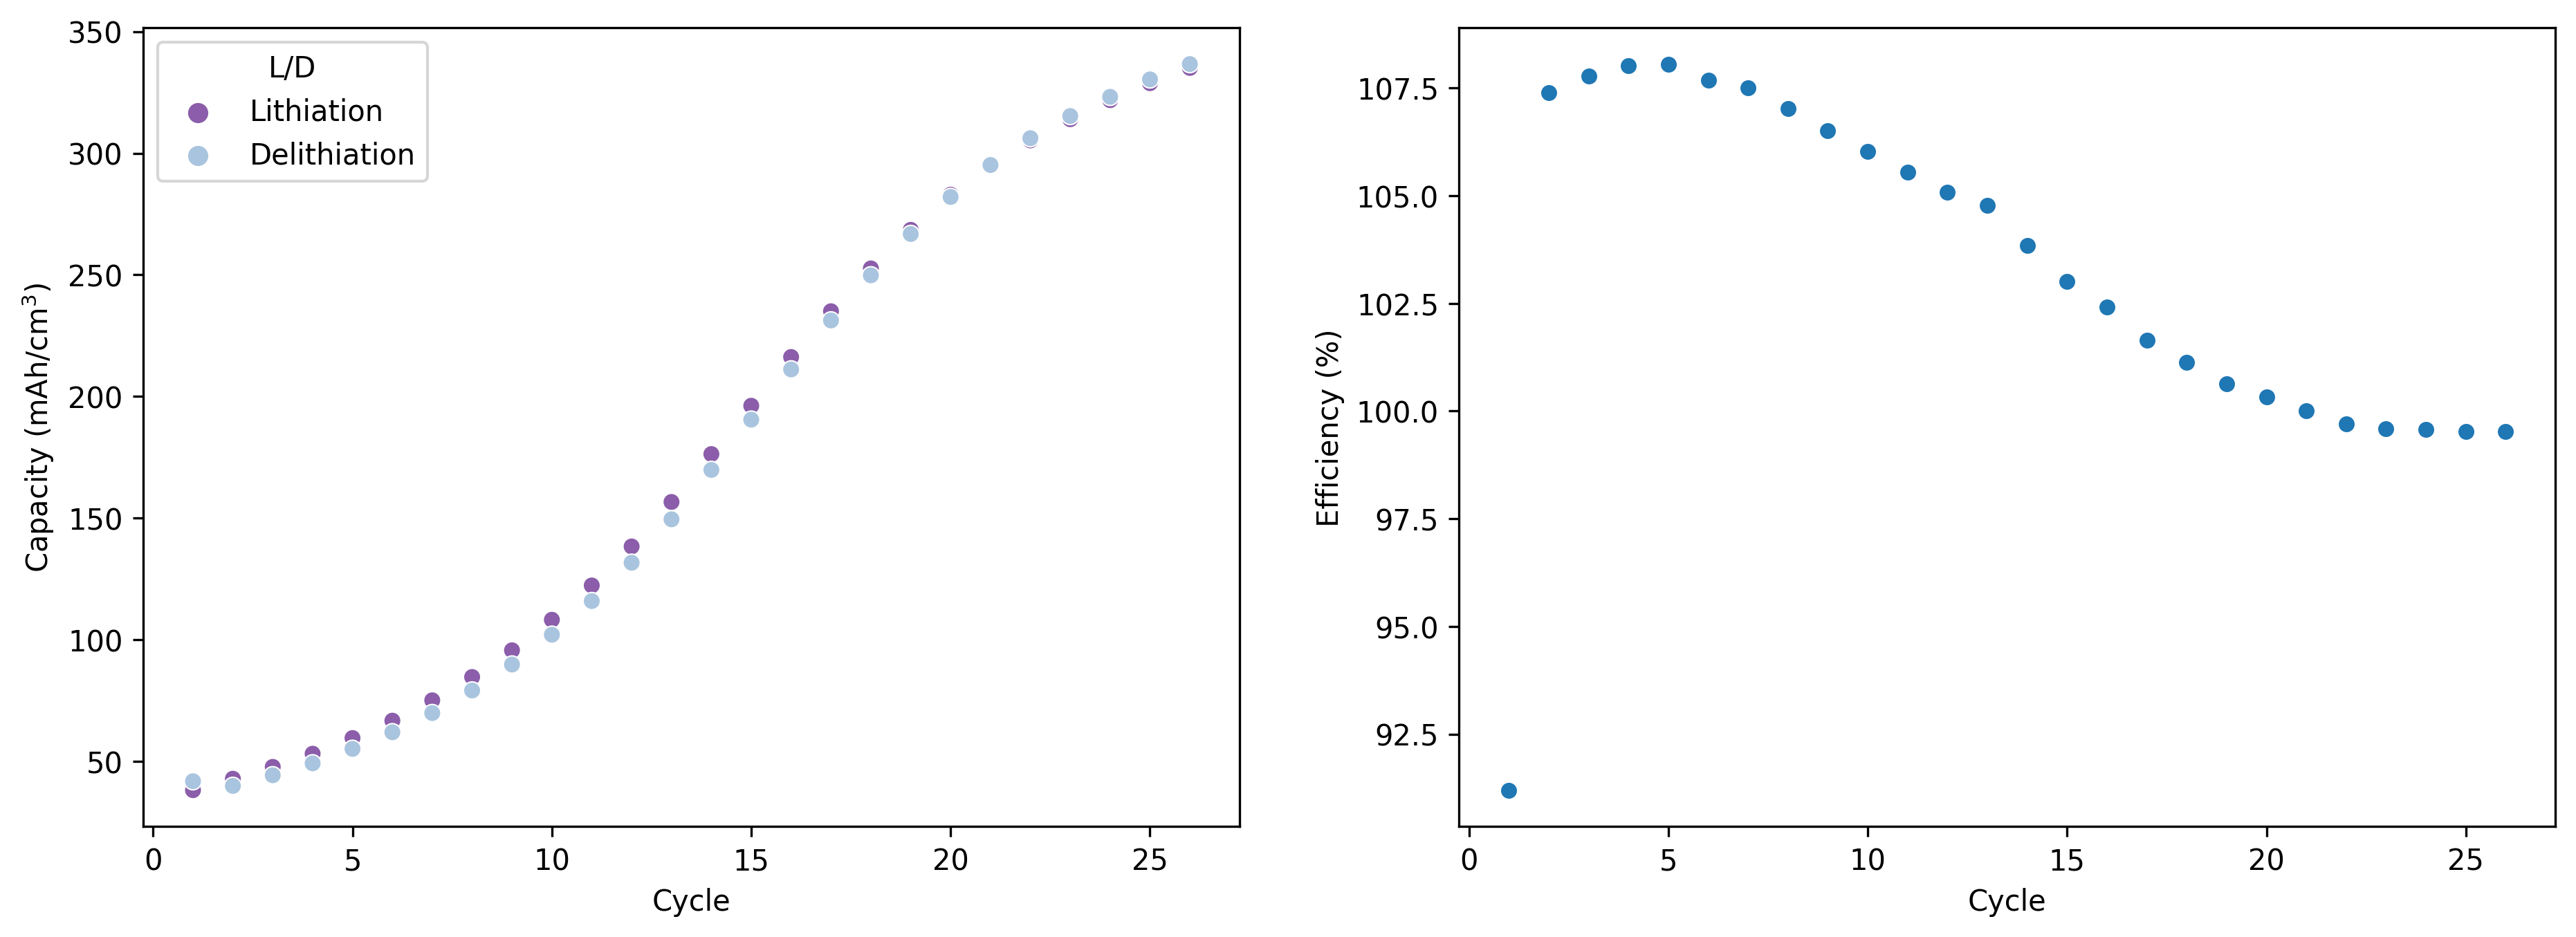

In [54]:
# ALD TiO2 round2
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\ALD TiO2\90cycles'
# setup_files(path)
area = 3.1416
thickness = 90
sample = 'LMO2h ALD TIO2 7nm'
ald_tio2 = cc(path, area, thickness, sample )
ald_tio2_eis = eis(path, sample)

cc_plot(ald_tio2, sample, 300)
# eis_plot(ald_tio2_eis, 200)


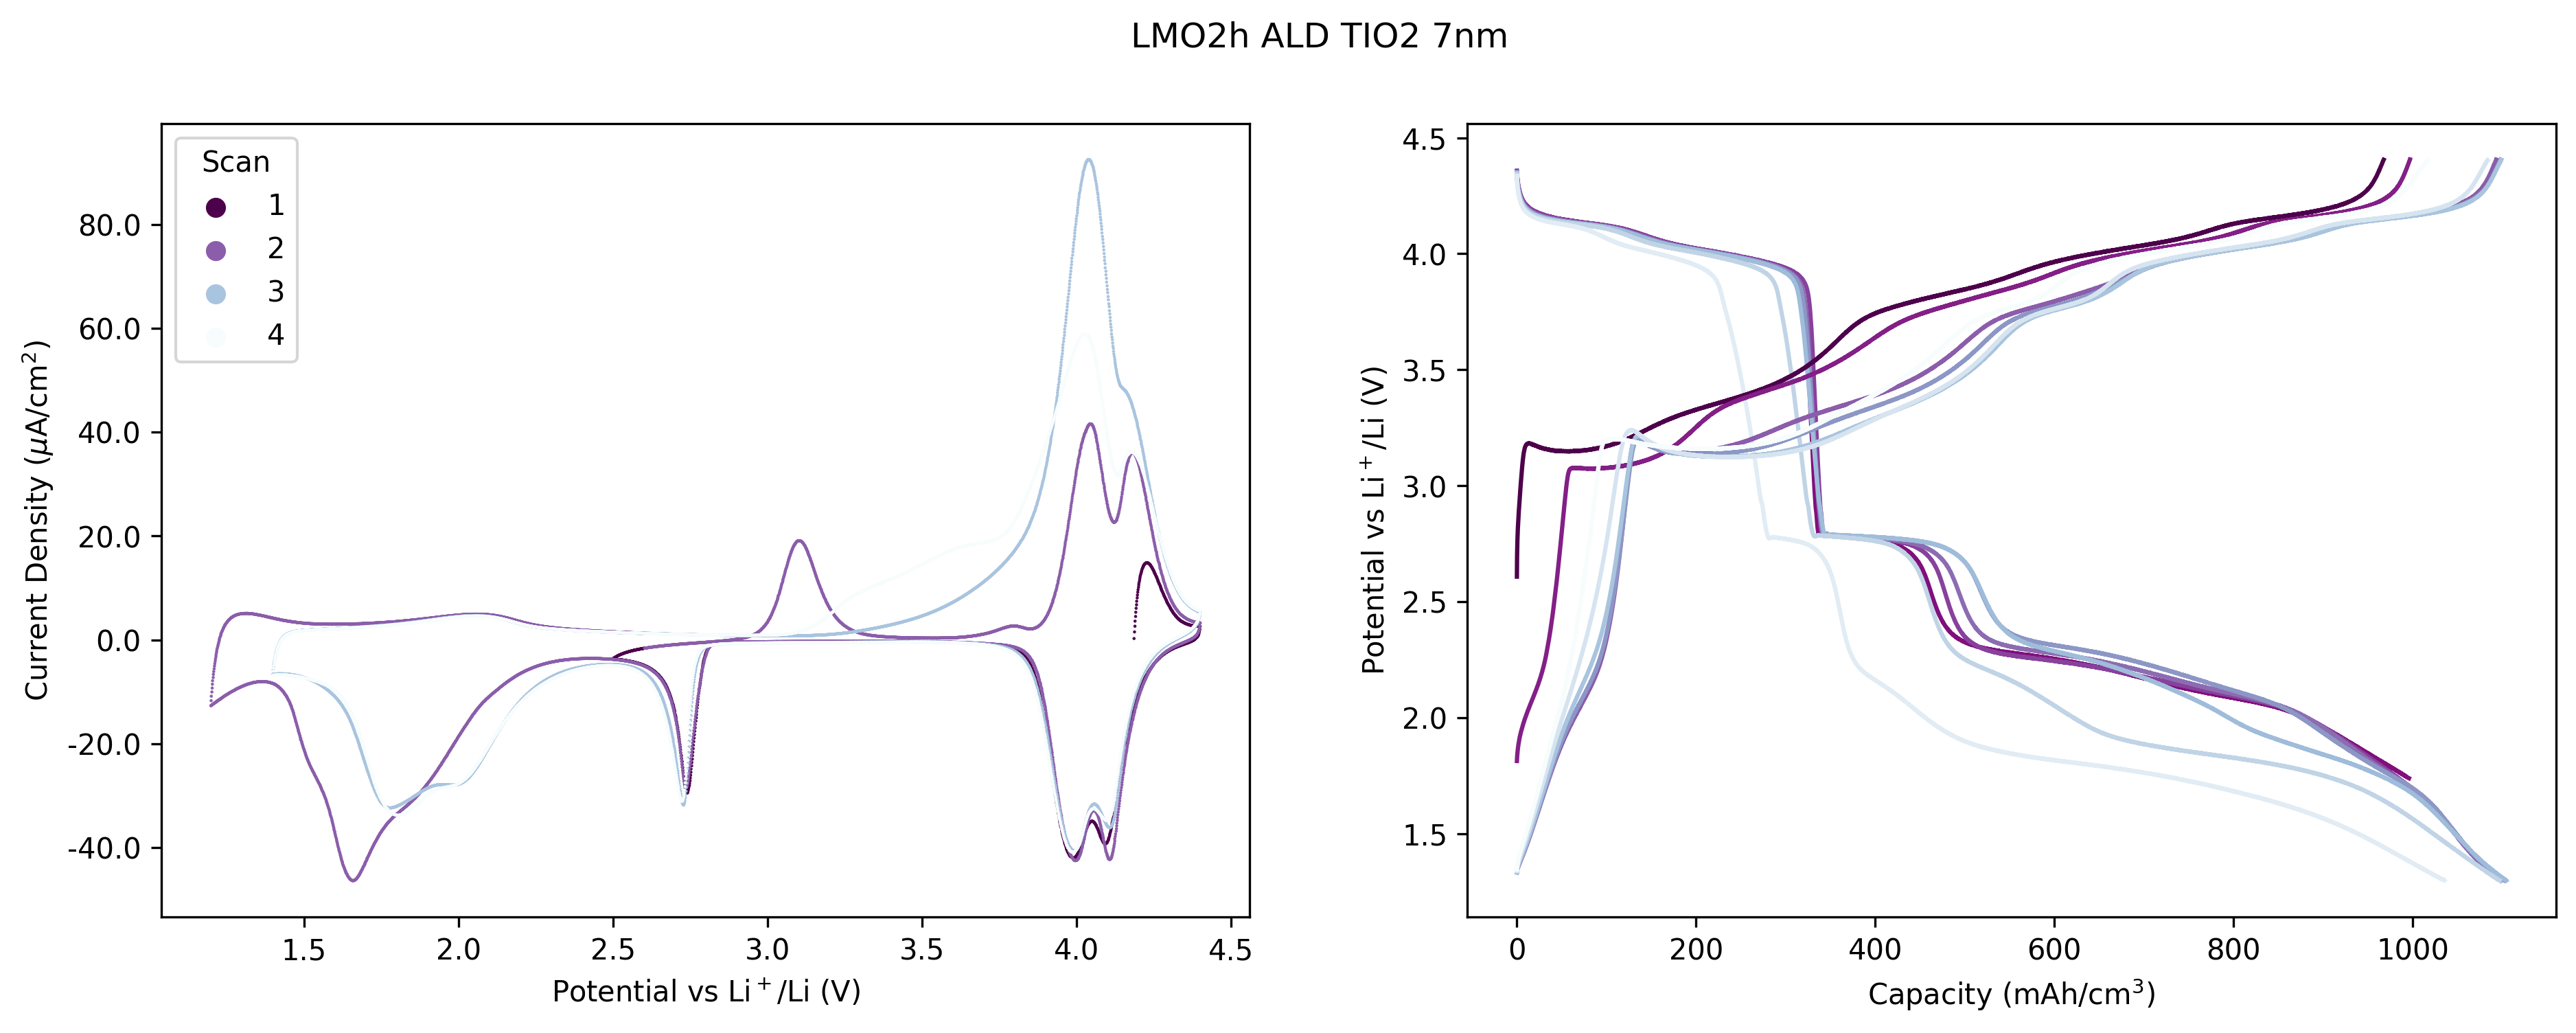

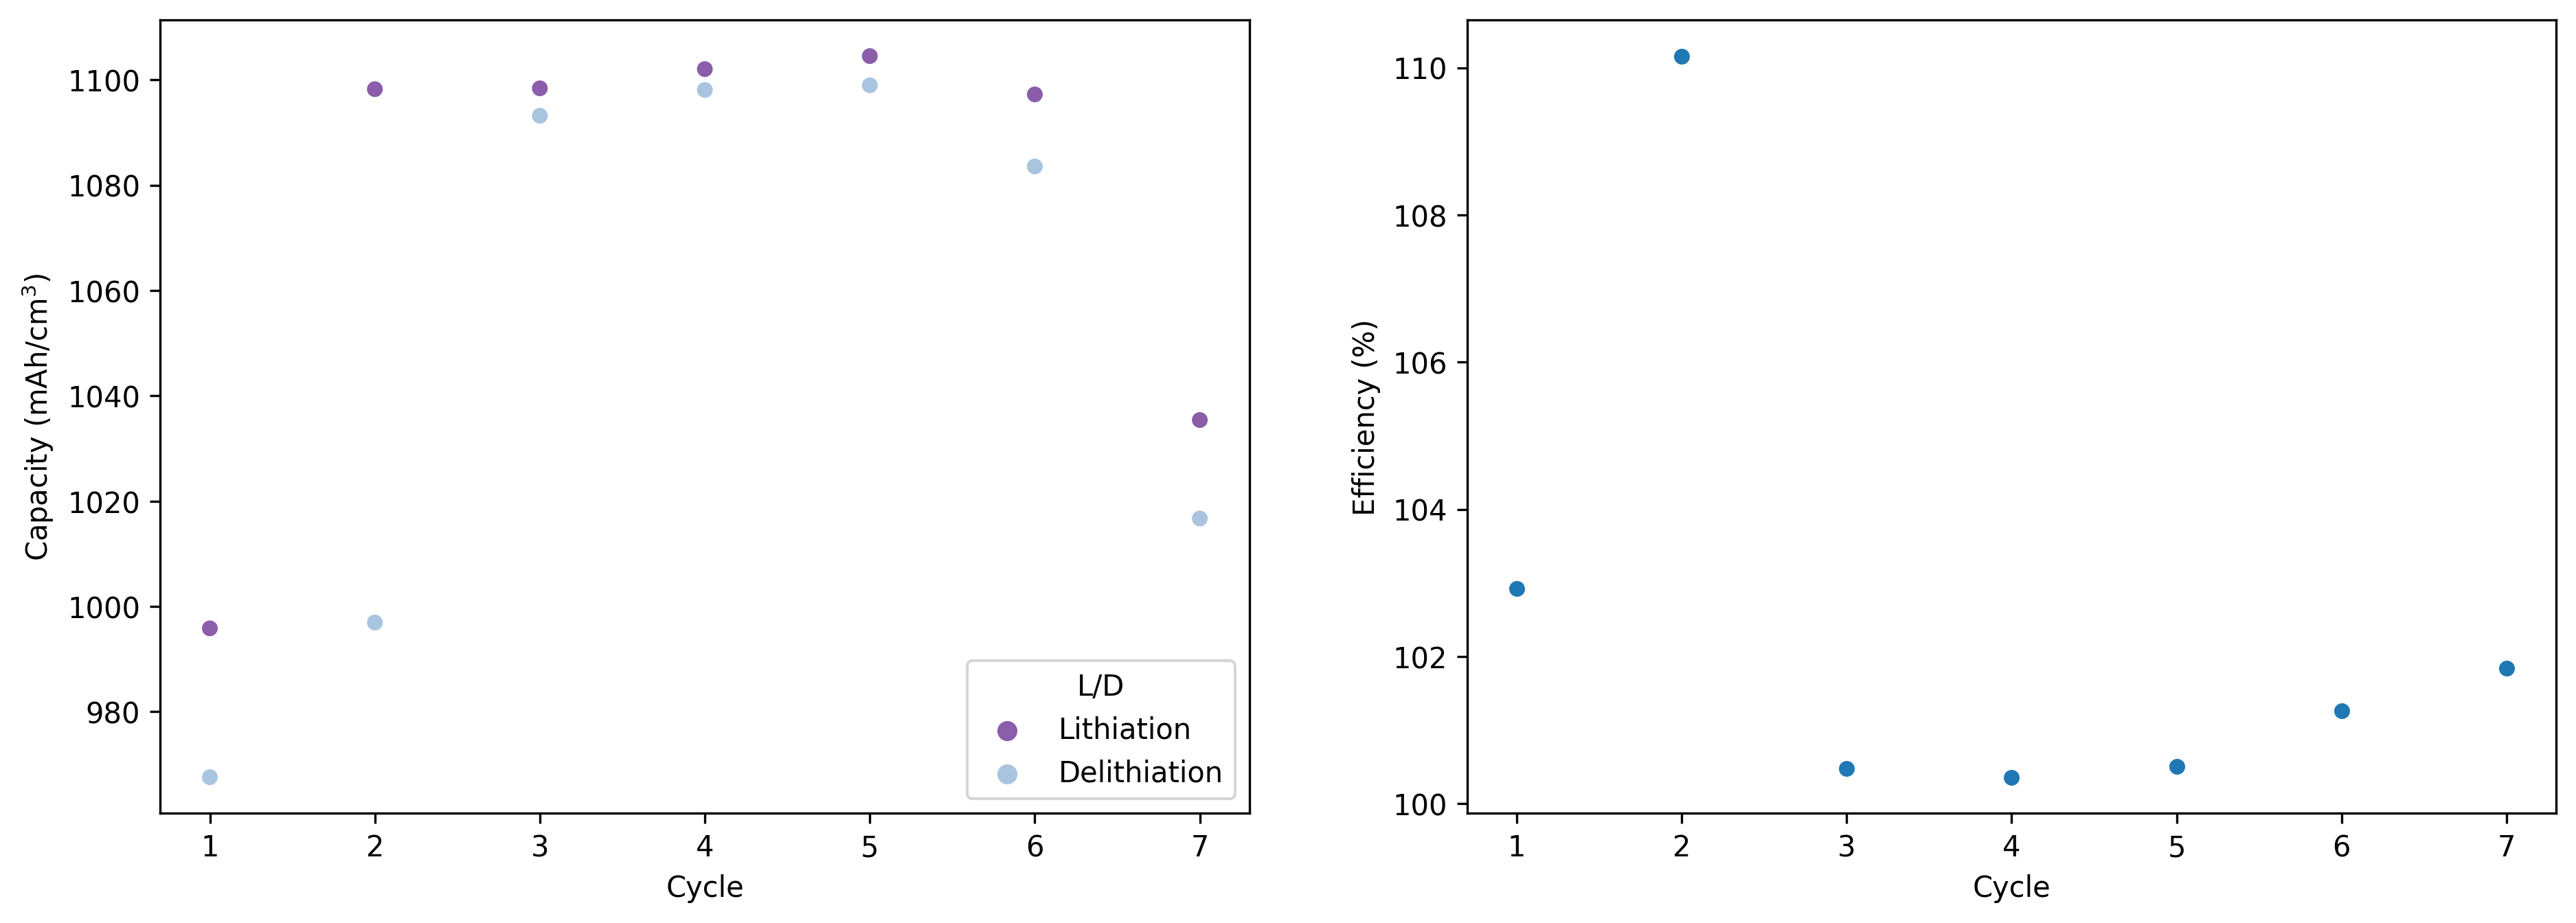

In [55]:
# ALD TiO2 90 cycles extended window
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\ALD TiO2\90cycles_ext'
# setup_files(path)
area = 3.1416
thickness = 90
sample = 'LMO2h ALD TIO2 7nm'
ald_tio2_ext = cc(path, area, thickness, sample )
#cc_ext
# ald_tio2_eis = eis(path, sample)

cc_plot(ald_tio2_ext, sample, 300)
# eis_plot(ald_tio2_eis, 200)

In [ ]:
# TLM method

N = 100 # number of fingers
w = 10e-4 # cm
L = 0.5 # cm           5e3 um
col_tlm = ['Resistance ($\Omega$)', 'Spacing ($\mu$m)']
def tlm(path):
    file_list = [os.path.join(path, i) for i in os.listdir(path)]
    
    def line(x, m, b):
        return x * m + b
    
    def w_contact(s):
        w_s = (2 * N * (w + L + s)) - L - s
        return w_s.mean()
        
    def tlm_model(s, r_s, l_t): # l_t
        return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)
        # return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)
    
    line_mod = Model(line)
    line_params = line_mod.make_params(m = 1, b = 1)
    tlm_mod = Model(tlm_model)
    tlm_params = tlm_mod.make_params(r_s = 1e4, l_t = 1)
    tlm_params['l_t'].set(value = 1, min = 0)
    
    values = pd.DataFrame(columns = col_tlm)
    n = 0
    for file in file_list:
        df = pd.read_csv(file, sep = ';', skiprows = 1, names = col_iv)
        result = line_mod.fit(df[col_iv[1]], line_params, x = df[col_iv[0]])
        r = 1 / result.values['m']
        spacing = float(file[-10:-8]) * 1e-4
        values.loc[n] = (r, spacing)
        n += 1

    result_tlm = tlm_mod.fit(values[col_tlm[0]], tlm_params, s = values[col_tlm[1]])
    print(result_tlm.fit_report())
    print('LMO (1 / sheet resistance) = ' + str(1/result_tlm.values['r_s']))
    width_avg = w_contact(values[col_tlm[1]])
    rc = (tlm_mod.eval(result_tlm.params, s = 0)) / 2
    lt = result_tlm.values['l_t']
    p_c = rc * lt * width_avg
    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    # contact_resistance = tlm_mod.eval(result_tlm.params, s = 0) / 2
    # print(result_tlm.params)
    
    fig, ax = plt.subplots(dpi = 100)
    sns.scatterplot(data = values, x = col_tlm[1], y = col_tlm[0])
    # sns.lineplot(x = values[col_tlm[1]], y = result_tlm.best_fit)
    sns.lineplot(x = np.array([-10e-4, 20e-4]), y = tlm_mod.eval(result_tlm.params, s = np.array([-10e-4, 20e-4])))
    ax.xaxis.set_major_formatter(formatter_1) # to show in um
    plt.xlim(-5e-4, 23e-4)
    plt.ylim(-1e5, 4.5e5)
    plt.grid()
    # print('Contact Resistance ' + str(contact_resistance))
    


In [56]:
# # TLM L23 IDEA3 Prototype

# path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA3_TLM'
# tlm(path)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Contact Resistance\\IDEA3_TLM\\Pt on top'